# Chapter 7: Ensemble Learning and Random Forests

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

sklearn.__version__

'1.5.1'

In [2]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

## Voting Classifiers

In [3]:
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC


X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

voting_clf = VotingClassifier(
	estimators=[

		('lr', LogisticRegression(random_state=42)),
		('rf', RandomForestClassifier(random_state=42)),
		('svc', SVC(random_state=42))
		]
	)

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [4]:
for name, estimator in voting_clf.named_estimators_.items():
	print(name, estimator.score(X_test, y_test))

lr 0.864
rf 0.896
svc 0.896


In [5]:
voting_clf.predict(X_test[:1])

array([1], dtype=int64)

In [6]:
for name, estimator in voting_clf.named_estimators_.items():
	print(name, estimator.predict(X_test[:1]))

lr [1]
rf [1]
svc [0]


In [11]:
print("Individual classifiers:")
print("-"*50)
for name, estimator in voting_clf.named_estimators_.items():
	print("\t", name, estimator.score(X_test, y_test))

print("\nVoting classifier:")
print("-"*50)
print("\t", voting_clf.score(X_test, y_test))

Individual classifiers:
--------------------------------------------------
	 lr 0.864
	 rf 0.896
	 svc 0.896

Voting classifier:
--------------------------------------------------
	 0.912


In [13]:
voting_clf.voting = "soft"
voting_clf.named_estimators["svc"].probability = True
voting_clf.fit(X_train, y_train)
voting_clf.score(X_test, y_test)

0.92

## Bagging and Pasting

In [23]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bagg_clf_boots = BaggingClassifier(
	DecisionTreeClassifier(random_state=47), n_estimators=500,
	max_samples=100, bootstrap=True, random_state=47, n_jobs=-1,
	oob_score=True
	)

bagg_clf_boots.fit(X_train, y_train)
bagg_clf_boots.oob_score_, bagg_clf_boots.score(X_test, y_test)

(0.9253333333333333, 0.912)

In [24]:
bagg_clf_paste = BaggingClassifier(
	DecisionTreeClassifier(random_state=47), n_estimators=500,
	max_samples=100, bootstrap=False, random_state=47, n_jobs=-1
	)

bagg_clf_paste.fit(X_train, y_train)
bagg_clf_paste.score(X_test, y_test)

0.912

In [26]:
bagg_clf_boots.oob_decision_function_[:3]

array([[0.31472081, 0.68527919],
       [0.41237113, 0.58762887],
       [1.        , 0.        ]])

### Random Patches and Random Subspaces

## Random Forests

In [30]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)

rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

rnd_clf.score(X_test, y_test)

0.912

### Feature Importance

In [34]:
from sklearn.datasets import load_iris
iris = load_iris(as_frame=True)
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris.data, iris.target)
for score, name in zip(rnd_clf.feature_importances_, iris.data.columns):
	print(round(score, 2), "-", name)

0.11 - sepal length (cm)
0.02 - sepal width (cm)
0.44 - petal length (cm)
0.42 - petal width (cm)


## Boosting

### AdaBoost

In [38]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
	DecisionTreeClassifier(max_depth=1), n_estimators=30, learning_rate=0.5, random_state=42
	)

ada_clf.fit(X_train, y_train)
ada_clf.score(X_test, y_test)

c:\Users\Denis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


0.904

### Gradient Boosting

In [ ]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor

# Generate quadratic noisy data
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3 * X[:, 0] ** 2 + 0.05 * np.random.randn(100) # y = 3x² + Gaussian noise

# First tree: Trained on the data
tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

# Second tree: Trained on the residual errors of the first tree
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

# Third tree: Trained on the residual errors of the second tree
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

# Make predictions 
X_new = np.array([[-0.4], [0.], [0.5]])
sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

array([0.49484029, 0.04021166, 0.75026781])

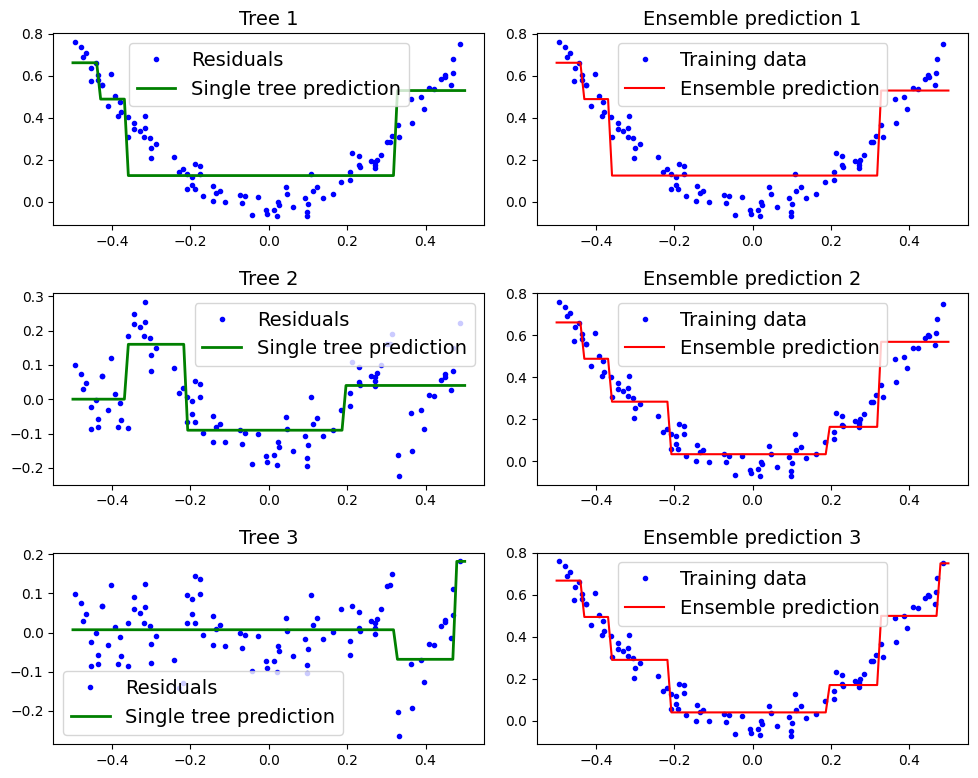

In [67]:
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(10, 8))
trees = [tree_reg1, tree_reg2, tree_reg3]

ys = [y, y2, y3]
for i, (tree, ax, y_now) in enumerate(zip(trees, axes, ys)):
	X_new = np.linspace(-0.5, 0.5, 100).reshape(-1, 1)
	ax[0].plot(X, y_now, "b.", label='Residuals')
	ax[0].plot(X_new, tree.predict(X_new), "g-", linewidth=2, label='Single tree prediction')
	ax[0].set_title(f"Tree {i+1}")
	ax[0].legend()
	ax[1].plot(X, y, "b.", label='Training data')
	ax[1].plot(X_new, sum(tree.predict(X_new) for tree in trees[:i+1]), "r-", label='Ensemble prediction')
	ax[1].set_title(f"Ensemble prediction {i+1}")
	ax[1].legend()

plt.tight_layout()

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(
	max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42
	)
gbrt.fit(X, y)
gbrt.score(X, y)

0.9095502641012175

In [73]:
gbrt_best = GradientBoostingRegressor(
	max_depth=2, n_estimators=500,
	learning_rate=0.05, n_iter_no_change=10,
	random_state=42)

gbrt_best.fit(X, y)
gbrt_best.score(X, y), gbrt_best.n_estimators_

(0.9759700529797392, 92)

### Histogram-Based Gradient Boosting